# Section 1

In this notebook, we prepare plots for Section 1 of the manuscript.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml, config, datasets, visualisations

/home/eugen/miniconda3/nco/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_p = Path(config.DATA_BASE_PATH) / "Frozen_MiniAbsolut_ML_shuffled"
df = pd.read_csv(base_p / "closed_performance.tsv", sep='\t')
df.head()

,task,N_pos,N_neg,acc,recall,precision,f1
0,HIGH_VS_95LOW__3VRL__auto__0__42,10,10,0.40,0.6,0.428571,0.500000
1,HIGH_VS_LOOSER__3VRL__auto__0__42,10,10,0.45,0.8,0.470588,0.592593
2,ONE_VS_NINE__3VRL__auto__0__42,10,10,0.60,0.8,0.571429,0.666667
3,HIGH_VS_95LOW__3VRL__auto__1__42,10,10,0.40,0.6,0.428571,0.500000
4,HIGH_VS_LOOSER__3VRL__auto__1__42,10,10,0.45,0.8,0.470588,0.592593


In [3]:
records = []
for i, row in df.iterrows():
    task_str = row["task"]
    task = datasets.ClassificationTask.init_from_str(task_str)
    records.append({
        "task": task_str,
        "ag_pos": task.ag_pos,
        "ag_neg": task.ag_neg,
        "seed_id": task.seed_id,
        "split_id": task.split_id,
        "task_type": task.task_type.to_str(),
    })

df = pd.merge(df, pd.DataFrame(records), on="task")

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
df["task_type_clean"] = df["task_type"].map(map_task_type_to_clean)

df["acc_closed"] = df["acc"].astype(float)

In [4]:
print(df.shape)
df.head()

(1080, 14)


,task,N_pos,N_neg,acc,recall,precision,f1,ag_pos,ag_neg,seed_id,split_id,task_type,task_type_clean,acc_closed
0,HIGH_VS_95LOW__3VRL__auto__0__42,10,10,0.40,0.6,0.428571,0.500000,3VRL,auto,0,42,high_vs_95low,vs Non-binder,0.40
1,HIGH_VS_LOOSER__3VRL__auto__0__42,10,10,0.45,0.8,0.470588,0.592593,3VRL,auto,0,42,high_vs_looser,vs Weak,0.45
2,ONE_VS_NINE__3VRL__auto__0__42,10,10,0.60,0.8,0.571429,0.666667,3VRL,auto,0,42,1v9,vs 9,0.60
3,HIGH_VS_95LOW__3VRL__auto__1__42,10,10,0.40,0.6,0.428571,0.500000,3VRL,auto,1,42,high_vs_95low,vs Non-binder,0.40
4,HIGH_VS_LOOSER__3VRL__auto__1__42,10,10,0.45,0.8,0.470588,0.592593,3VRL,auto,1,42,high_vs_looser,vs Weak,0.45


## vs Non-binder, vs Weak, vs 9 performances

In [5]:
# Get order of antigens by high_vs_looser performance
ag_order = df.loc[df["task_type"] == "high_vs_looser"].groupby("ag_pos")["acc_closed"].mean().sort_values(ascending=False).index.to_list()

In [6]:
task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
task_clean_order = [map_task_type_to_clean[x] for x in task_order]

/tmp/ipykernel_666166/2090162515.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


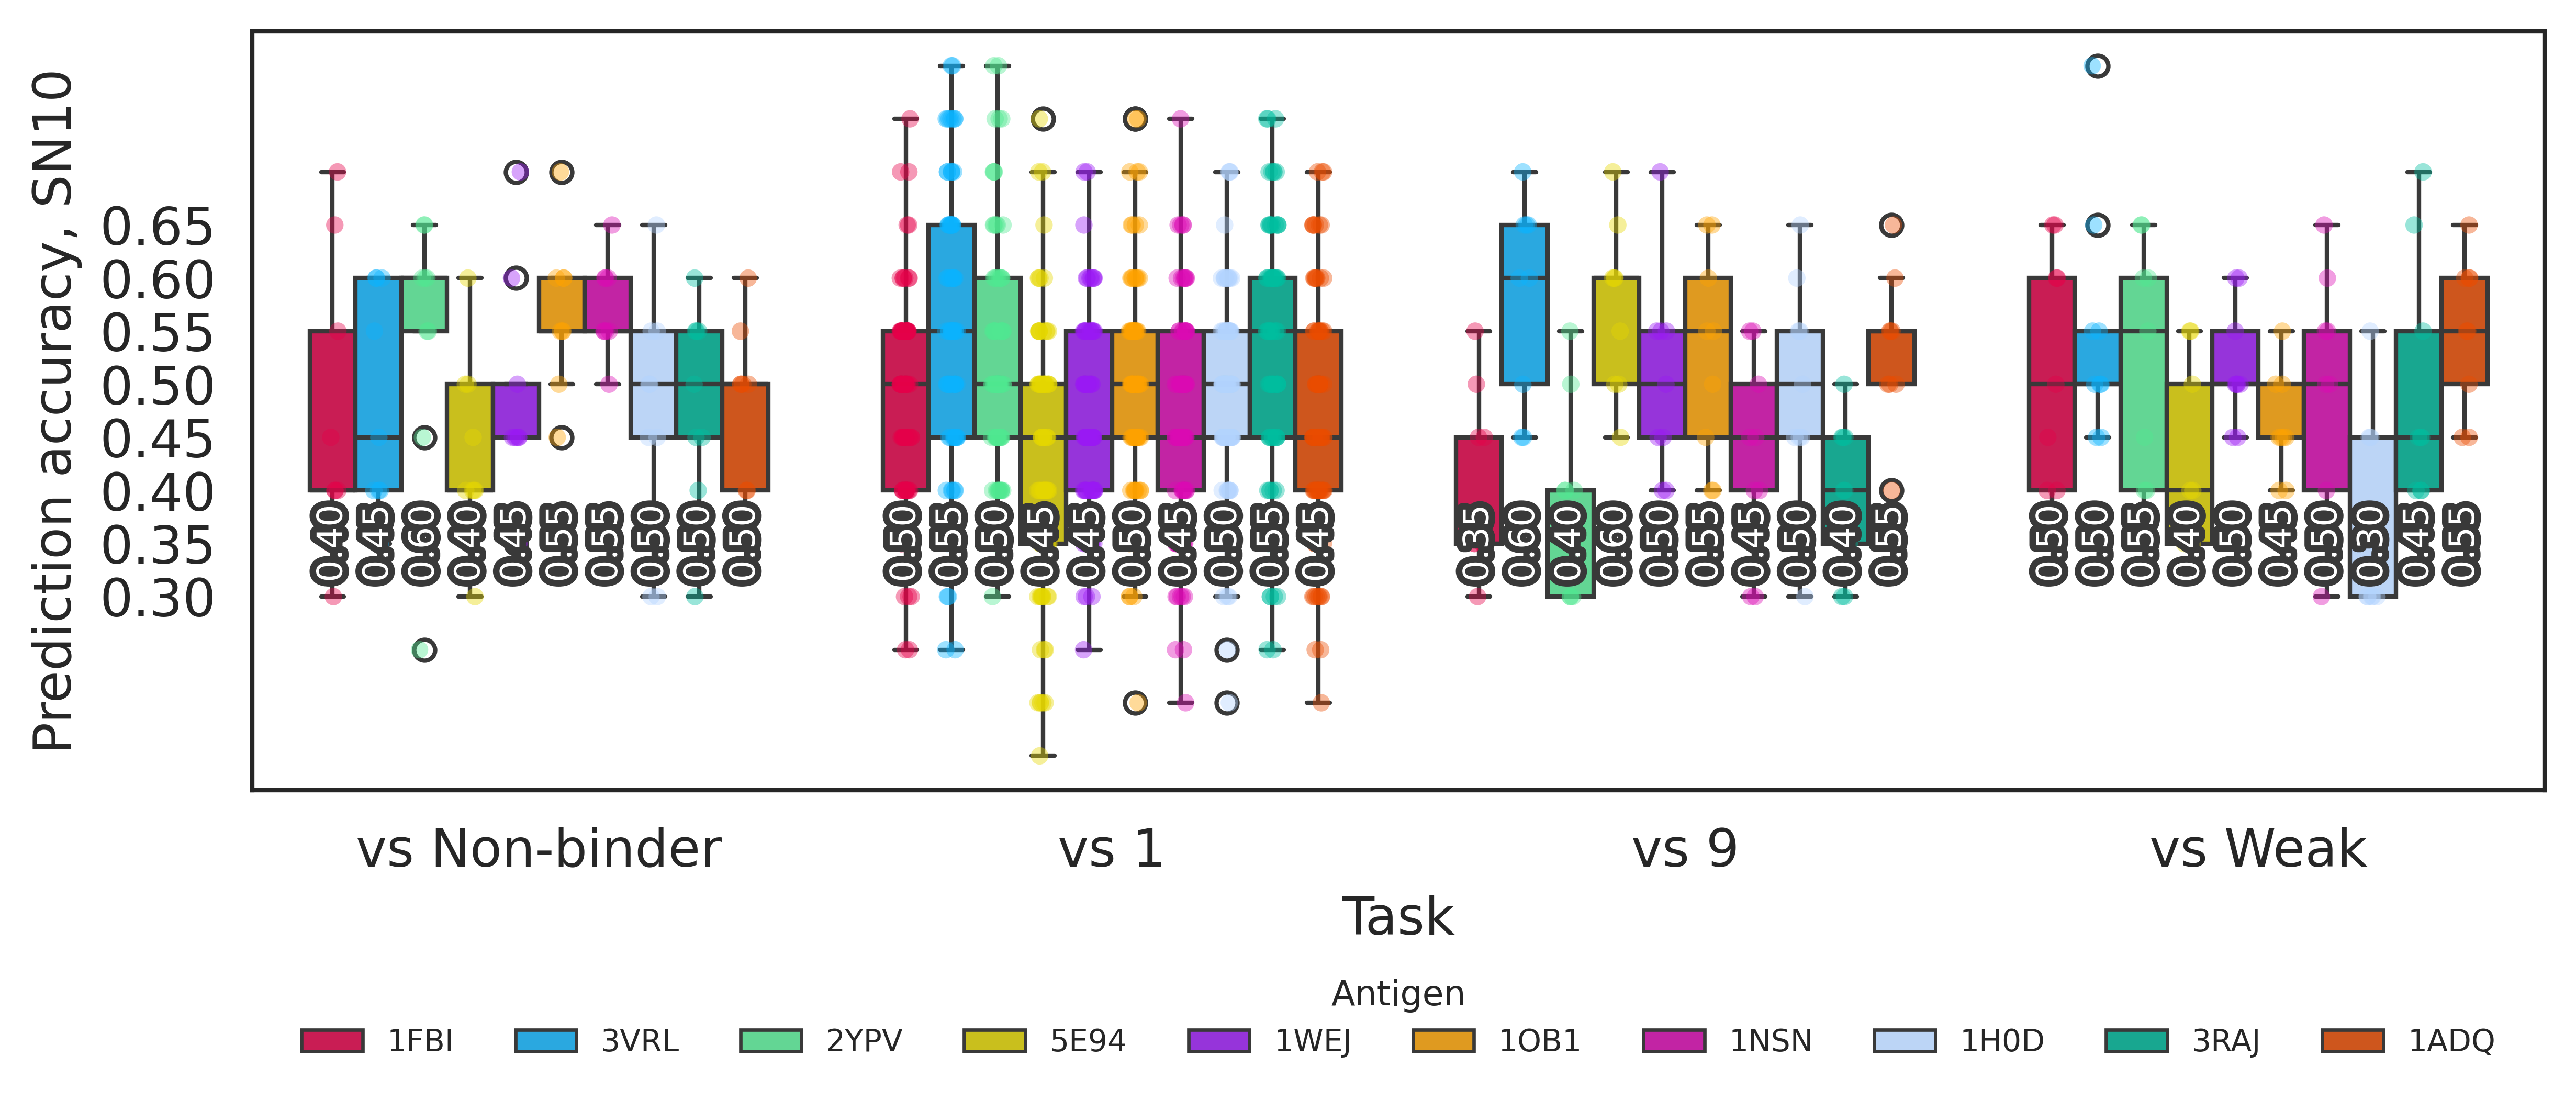

In [7]:
yticks = np.arange(0.3, 0.7, 0.05)
yaxis_title = "Prediction accuracy, SN10"
ag_order = visualisations.PlotParams.order_antigens
task_order = visualisations.PlotParams.order_tasks
task_clean_order = visualisations.PlotParams.order_tasks_clean
cmap = visualisations.PlotParams.cmap_antigens

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.boxplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=cmap,
    boxprops=dict(alpha=1),
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=cmap,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

visualisations.add_median_labels(ax, y_level=0.35, fontsize=8)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel(yaxis_title, fontsize=12)
ax.set_yticks(yticks)

fig.show()

In [8]:
df.groupby("task_type")["acc_closed"].agg(["mean", "std"])

,mean,std
task_type,,
1v1,0.488704,0.116070
1v9,0.485000,0.108734
high_vs_95low,0.499444,0.103450
high_vs_looser,0.487778,0.106610


/tmp/ipykernel_666166/552326829.py:9: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.stripplot(
/tmp/ipykernel_666166/552326829.py:26: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_666166/552326829.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


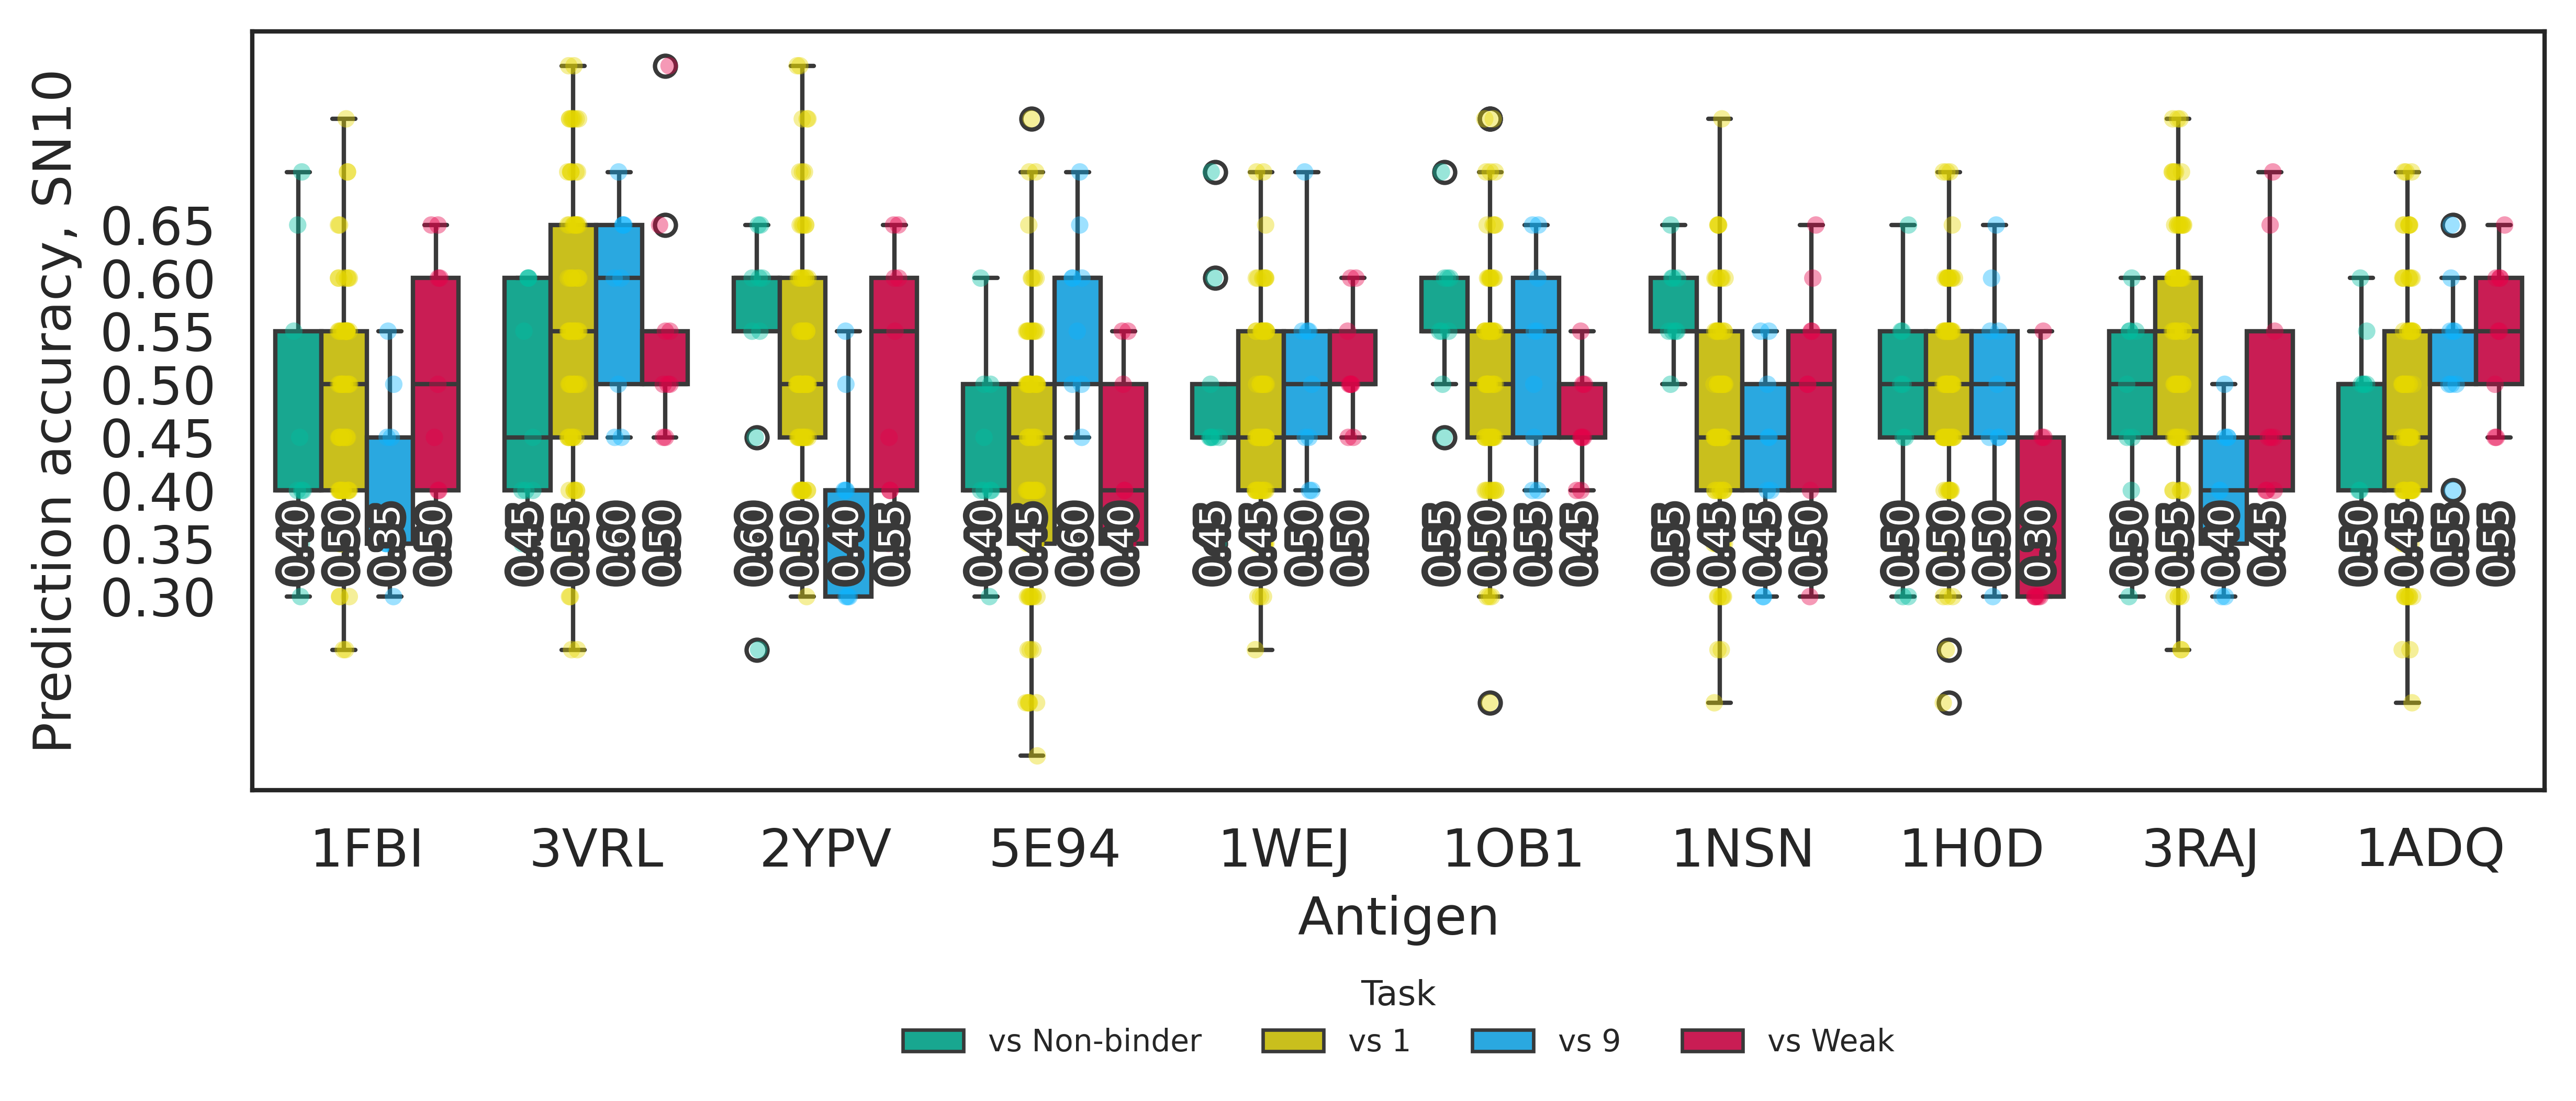

In [9]:
cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)


## Add data points on top of boxplot in low transparency
sns.stripplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type_clean",
    data=df,
    ax=ax,
    # Order on x axis
    order=ag_order,
    hue_order=map(lambda x: map_task_type_to_clean[x], ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]),
    # palette="Set2",
    palette=cmap,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

sns.boxplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type_clean",
    data=df,
    ax=ax,
    order=ag_order,
    boxprops=dict(alpha=1),  # a better solution is below
    hue_order=map(lambda x: map_task_type_to_clean[x], ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]),
    palette=cmap,
)
## Based on https://github.com/mwaskom/seaborn/issues/979#issuecomment-235082271
for patch in ax.artists:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, 0.1))


visualisations.add_median_labels(ax, y_level=0.35, fontsize=8)


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)

ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)

ax.set_yticks(yticks)
# Add legend under the plot, under x axis label
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

fig.show()

In [10]:
df.groupby("ag_pos")["acc_closed"].agg(["mean", "std"]).sort_values("mean", ascending=False)

,mean,std
ag_pos,,
3VRL,0.550000,0.123235
2YPV,0.512963,0.111776
3RAJ,0.507870,0.120583
1OB1,0.502315,0.102625
1ADQ,0.481944,0.109472
1H0D,0.477315,0.103532
1WEJ,0.474074,0.092847
1FBI,0.472685,0.107517
1NSN,0.470833,0.106807


In [11]:
# Add mean and std, std rounded to 3 decimal places
df.groupby("task_type")["acc_closed"].agg(["mean", "std"]).sort_values("mean", ascending=False).round(3).loc[
    task_order
]

,mean,std
task_type,,
high_vs_95low,0.499,0.103
1v1,0.489,0.116
1v9,0.485,0.109
high_vs_looser,0.488,0.107


## Entropy of slides

In [12]:
from NegativeClassOptimization.utils import jensen_shannon_divergence_slides 

# Compute JSD for each task
loader = datasets.FrozenMiniAbsolutMLLoader(base_p)
jsds = []
for task_str in df["task"]:
    task = datasets.ClassificationTask.init_from_str(task_str)
    
    try:
        loader.load(task, load_model=False)
    except:
        print(f"Failed to load {task_str}")
        raise

    slides_neg = task.test_dataset.query("binds_a_pos_ag == 0")["Slide"].to_list() # type: ignore
    slides_pos = task.test_dataset.query("binds_a_pos_ag == 1")["Slide"].to_list() # type: ignore
    jsd = jensen_shannon_divergence_slides(slides_neg, slides_pos)
    jsds.append(jsd)
df["jsd"] = jsds

vs 1
vs 1: r=-0.10, p=0.00
vs 9
vs 9: r=-0.15, p=0.16
vs Non-binder
vs Non-binder: r=-0.17, p=0.11
vs Weak
vs Weak: r=0.05, p=0.65


/tmp/ipykernel_666166/785033084.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


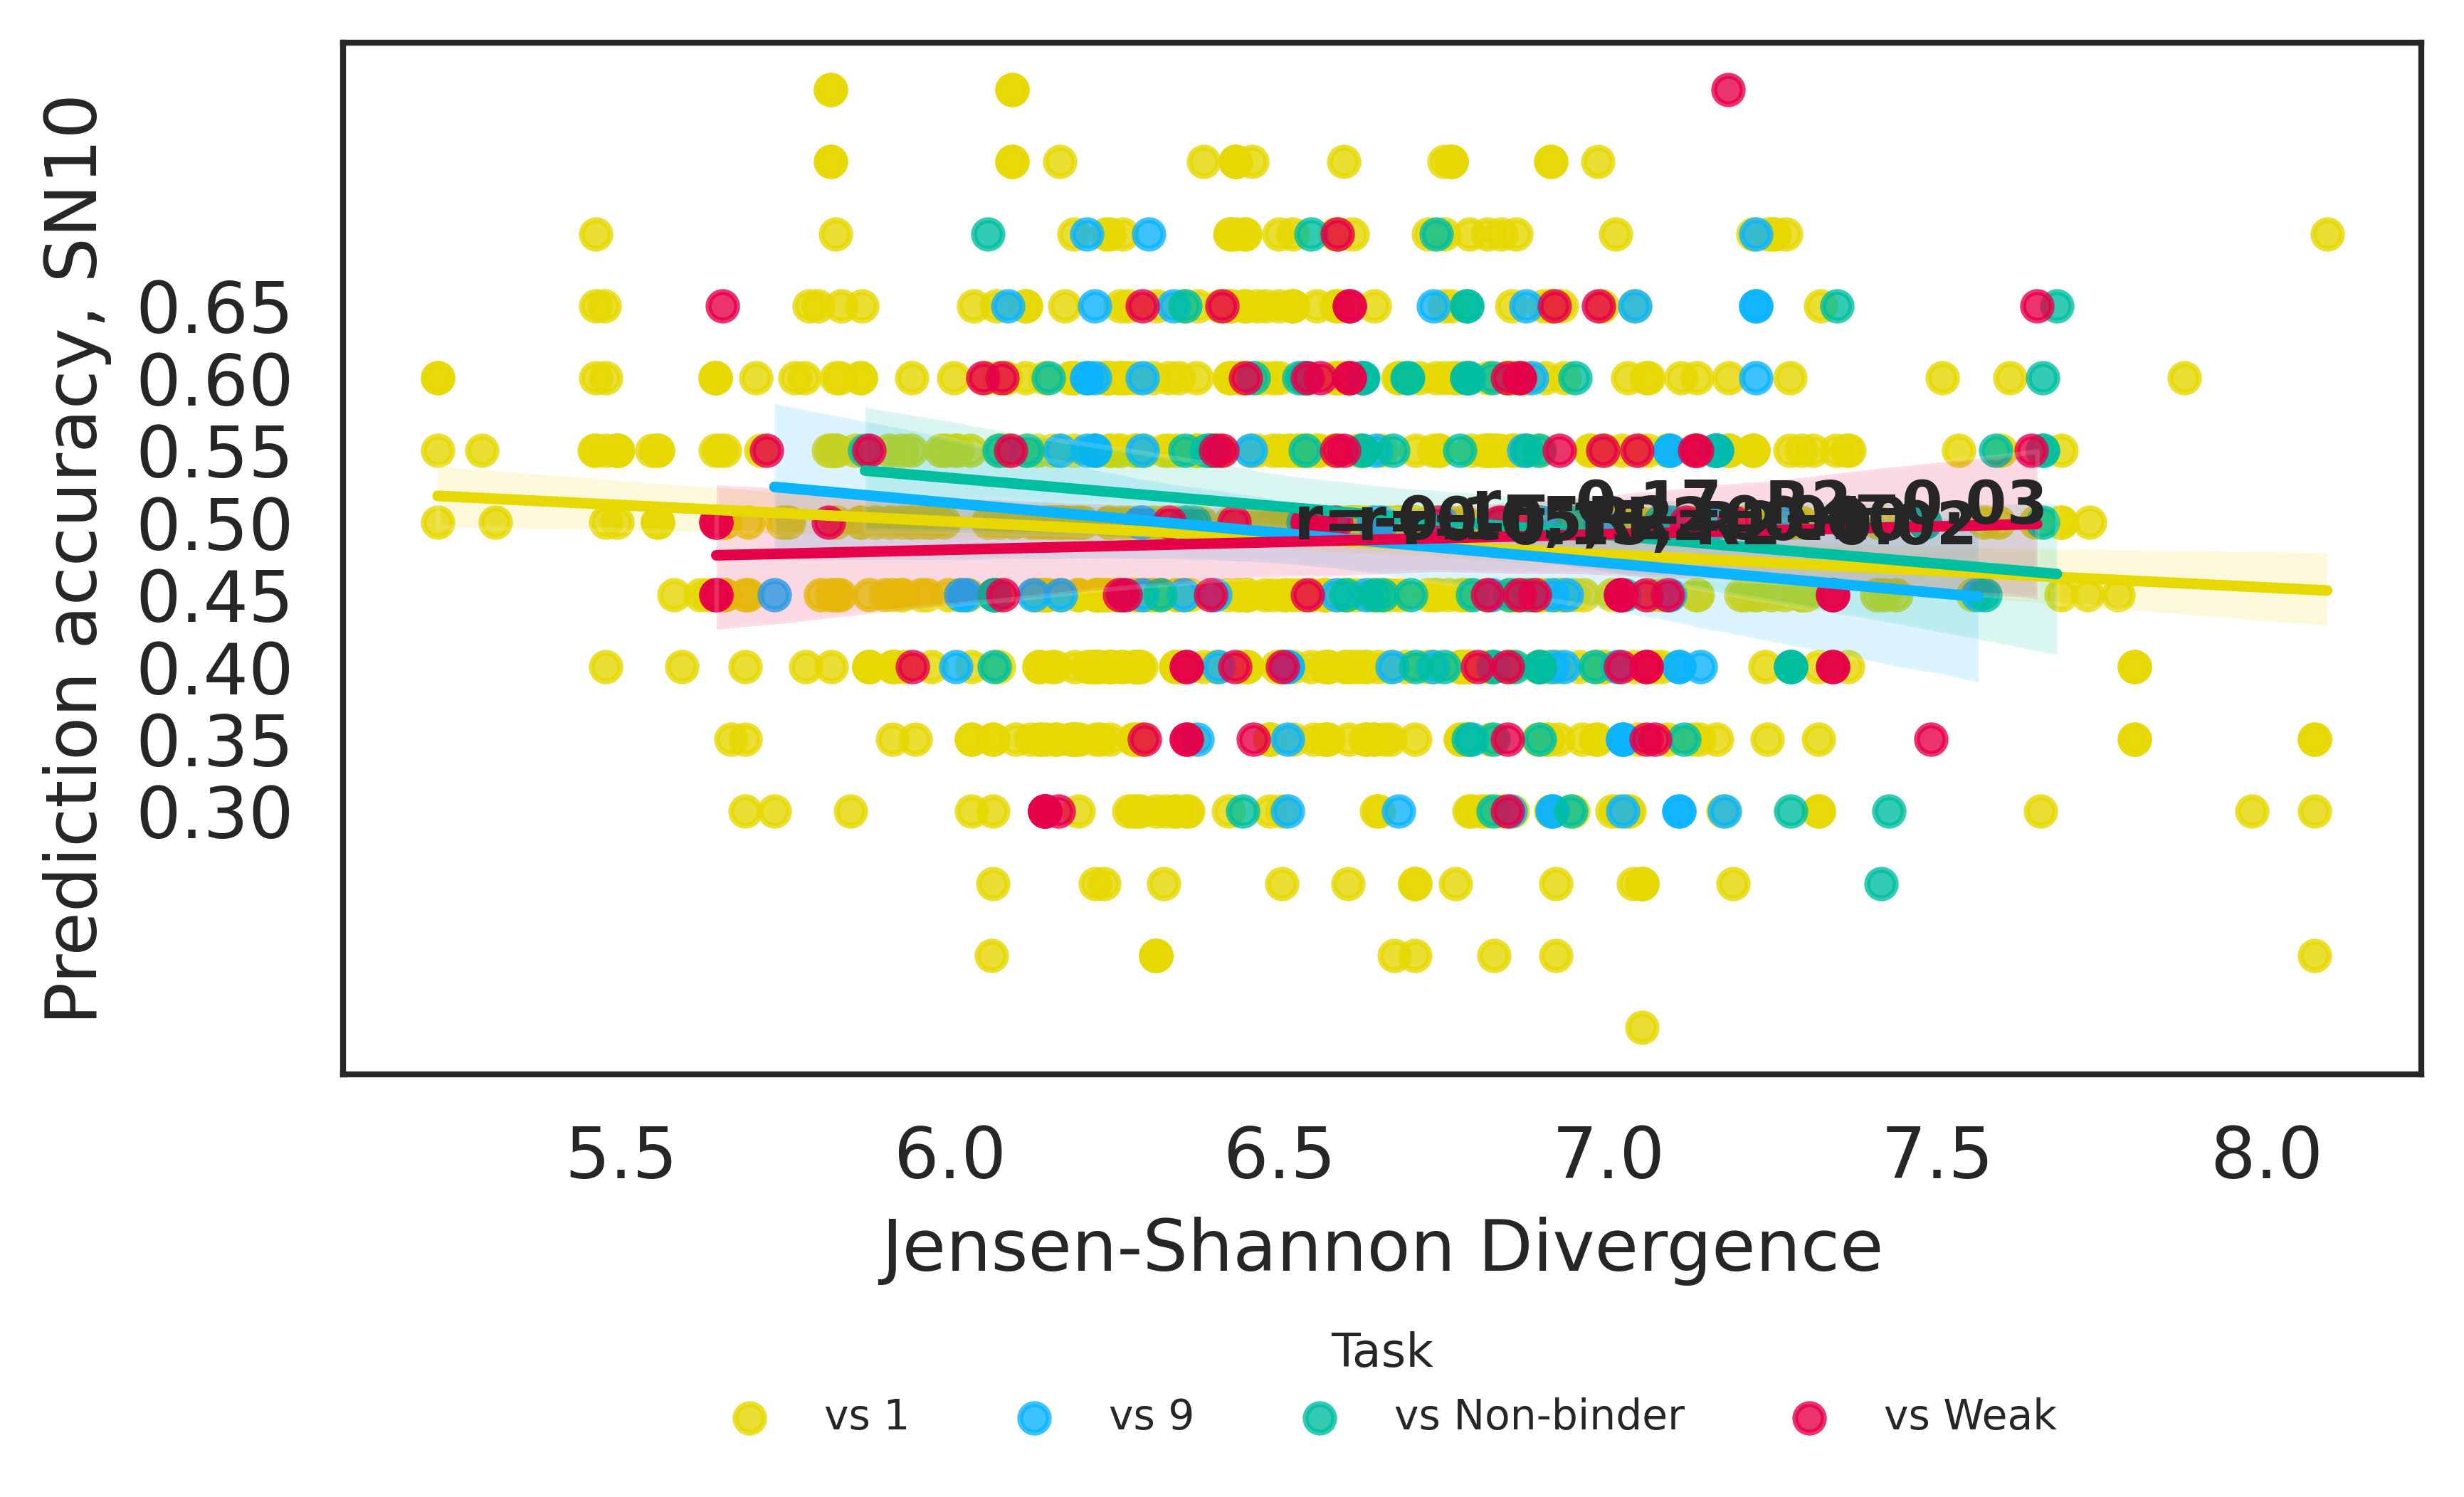

In [13]:
from scipy.stats import pearsonr

cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Line plot in seaborn with R2 regression
for i, df_g in df.groupby("task_type_clean"):
    print(i)
    color = cmap[visualisations.PlotParams.order_tasks_clean.index(i)] # type: ignore
    sns.regplot(
        x="jsd",
        y="acc_closed",
        data=df_g,
        scatter=True,
        color=color,
        ax=ax,
        label=i,
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["jsd"], df_g["acc_closed"])
    print(f"{i}: r={r:.2f}, p={pval:.2f}")
    # Add text with r and R2 at centroid
    x = df_g["jsd"].mean()
    y = df_g["acc_closed"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)

ax.set_yticks(yticks)

# Title
# ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)

fig.savefig("figures/1B.svg")
fig.show()

In [14]:
for i, df_g in df.groupby("task_type_clean"):
    # Compute Pearson correlation
    r, pval = pearsonr(df_g["jsd"], df_g["acc_closed"])
    print(f"{i}: r={r:.2f}, p={pval:.2f}")

vs 1: r=-0.10, p=0.00
vs 9: r=-0.15, p=0.16
vs Non-binder: r=-0.17, p=0.11
vs Weak: r=0.05, p=0.65


In [15]:
df.groupby("task_type_clean")["jsd"].agg(["mean", "std", "size"]).round(3).loc[task_clean_order]

,mean,std,size
task_type_clean,,,
vs Non-binder,6.793,0.442,90
vs 1,6.523,0.507,810
vs 9,6.686,0.394,90
vs Weak,6.618,0.476,90


In [16]:
df.groupby("task_type_clean").size()

task_type_clean
vs 1             810
vs 9              90
vs Non-binder     90
vs Weak           90
dtype: int64

## OOD

Precomputation of openset performances (Table 1C) is done in the notebook 15b.

In [18]:
df_o = pd.read_csv(f"{base_p}/openset_performance.tsv", sep="\t")
df_o["ag"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_pos)
df_o["task_1_type"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
df_o["task_2_type"] = df_o["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
def get_replicate_id(task_str):
    task = datasets.ClassificationTask.init_from_str(task_str)
    return str(task.seed_id) + "_" + str(task.split_id)
df_o["replicate_id"] = df_o["task_1"].apply(get_replicate_id)

print(df_o.shape)
df_o.head()

(74952, 10)


,task_1,task_2,acc,recall,precision,f1,ag,task_1_type,task_2_type,replicate_id
0,ONE_VS_ONE__1NSN__3VRL__0__42,ONE_VS_ONE__1NSN__3VRL__0__42,0.65,0.6,0.666667,0.631579,1NSN,1v1,1v1,0_42
1,ONE_VS_ONE__1NSN__3VRL__0__42,ONE_VS_ONE__1NSN__3VRL__1__42,0.65,0.6,0.666667,0.631579,1NSN,1v1,1v1,0_42
2,ONE_VS_ONE__1NSN__3VRL__0__42,ONE_VS_ONE__1NSN__3VRL__2__42,0.65,0.6,0.666667,0.631579,1NSN,1v1,1v1,0_42
3,ONE_VS_ONE__1NSN__3VRL__0__42,ONE_VS_ONE__1NSN__3VRL__3__42,0.65,0.6,0.666667,0.631579,1NSN,1v1,1v1,0_42
4,ONE_VS_ONE__1NSN__3VRL__0__42,ONE_VS_ONE__1NSN__3VRL__0__0,0.95,0.9,1.000000,0.947368,1NSN,1v1,1v1,0_42


In [19]:
df_o["model_task"] = df_o["task_1_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
df_o["test_task"] = df_o["task_2_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyError: "None of [Index(['vs Non-binder', 'vs 9', 'vs Weak'], dtype='object', name='model_task')] are in the [index]"

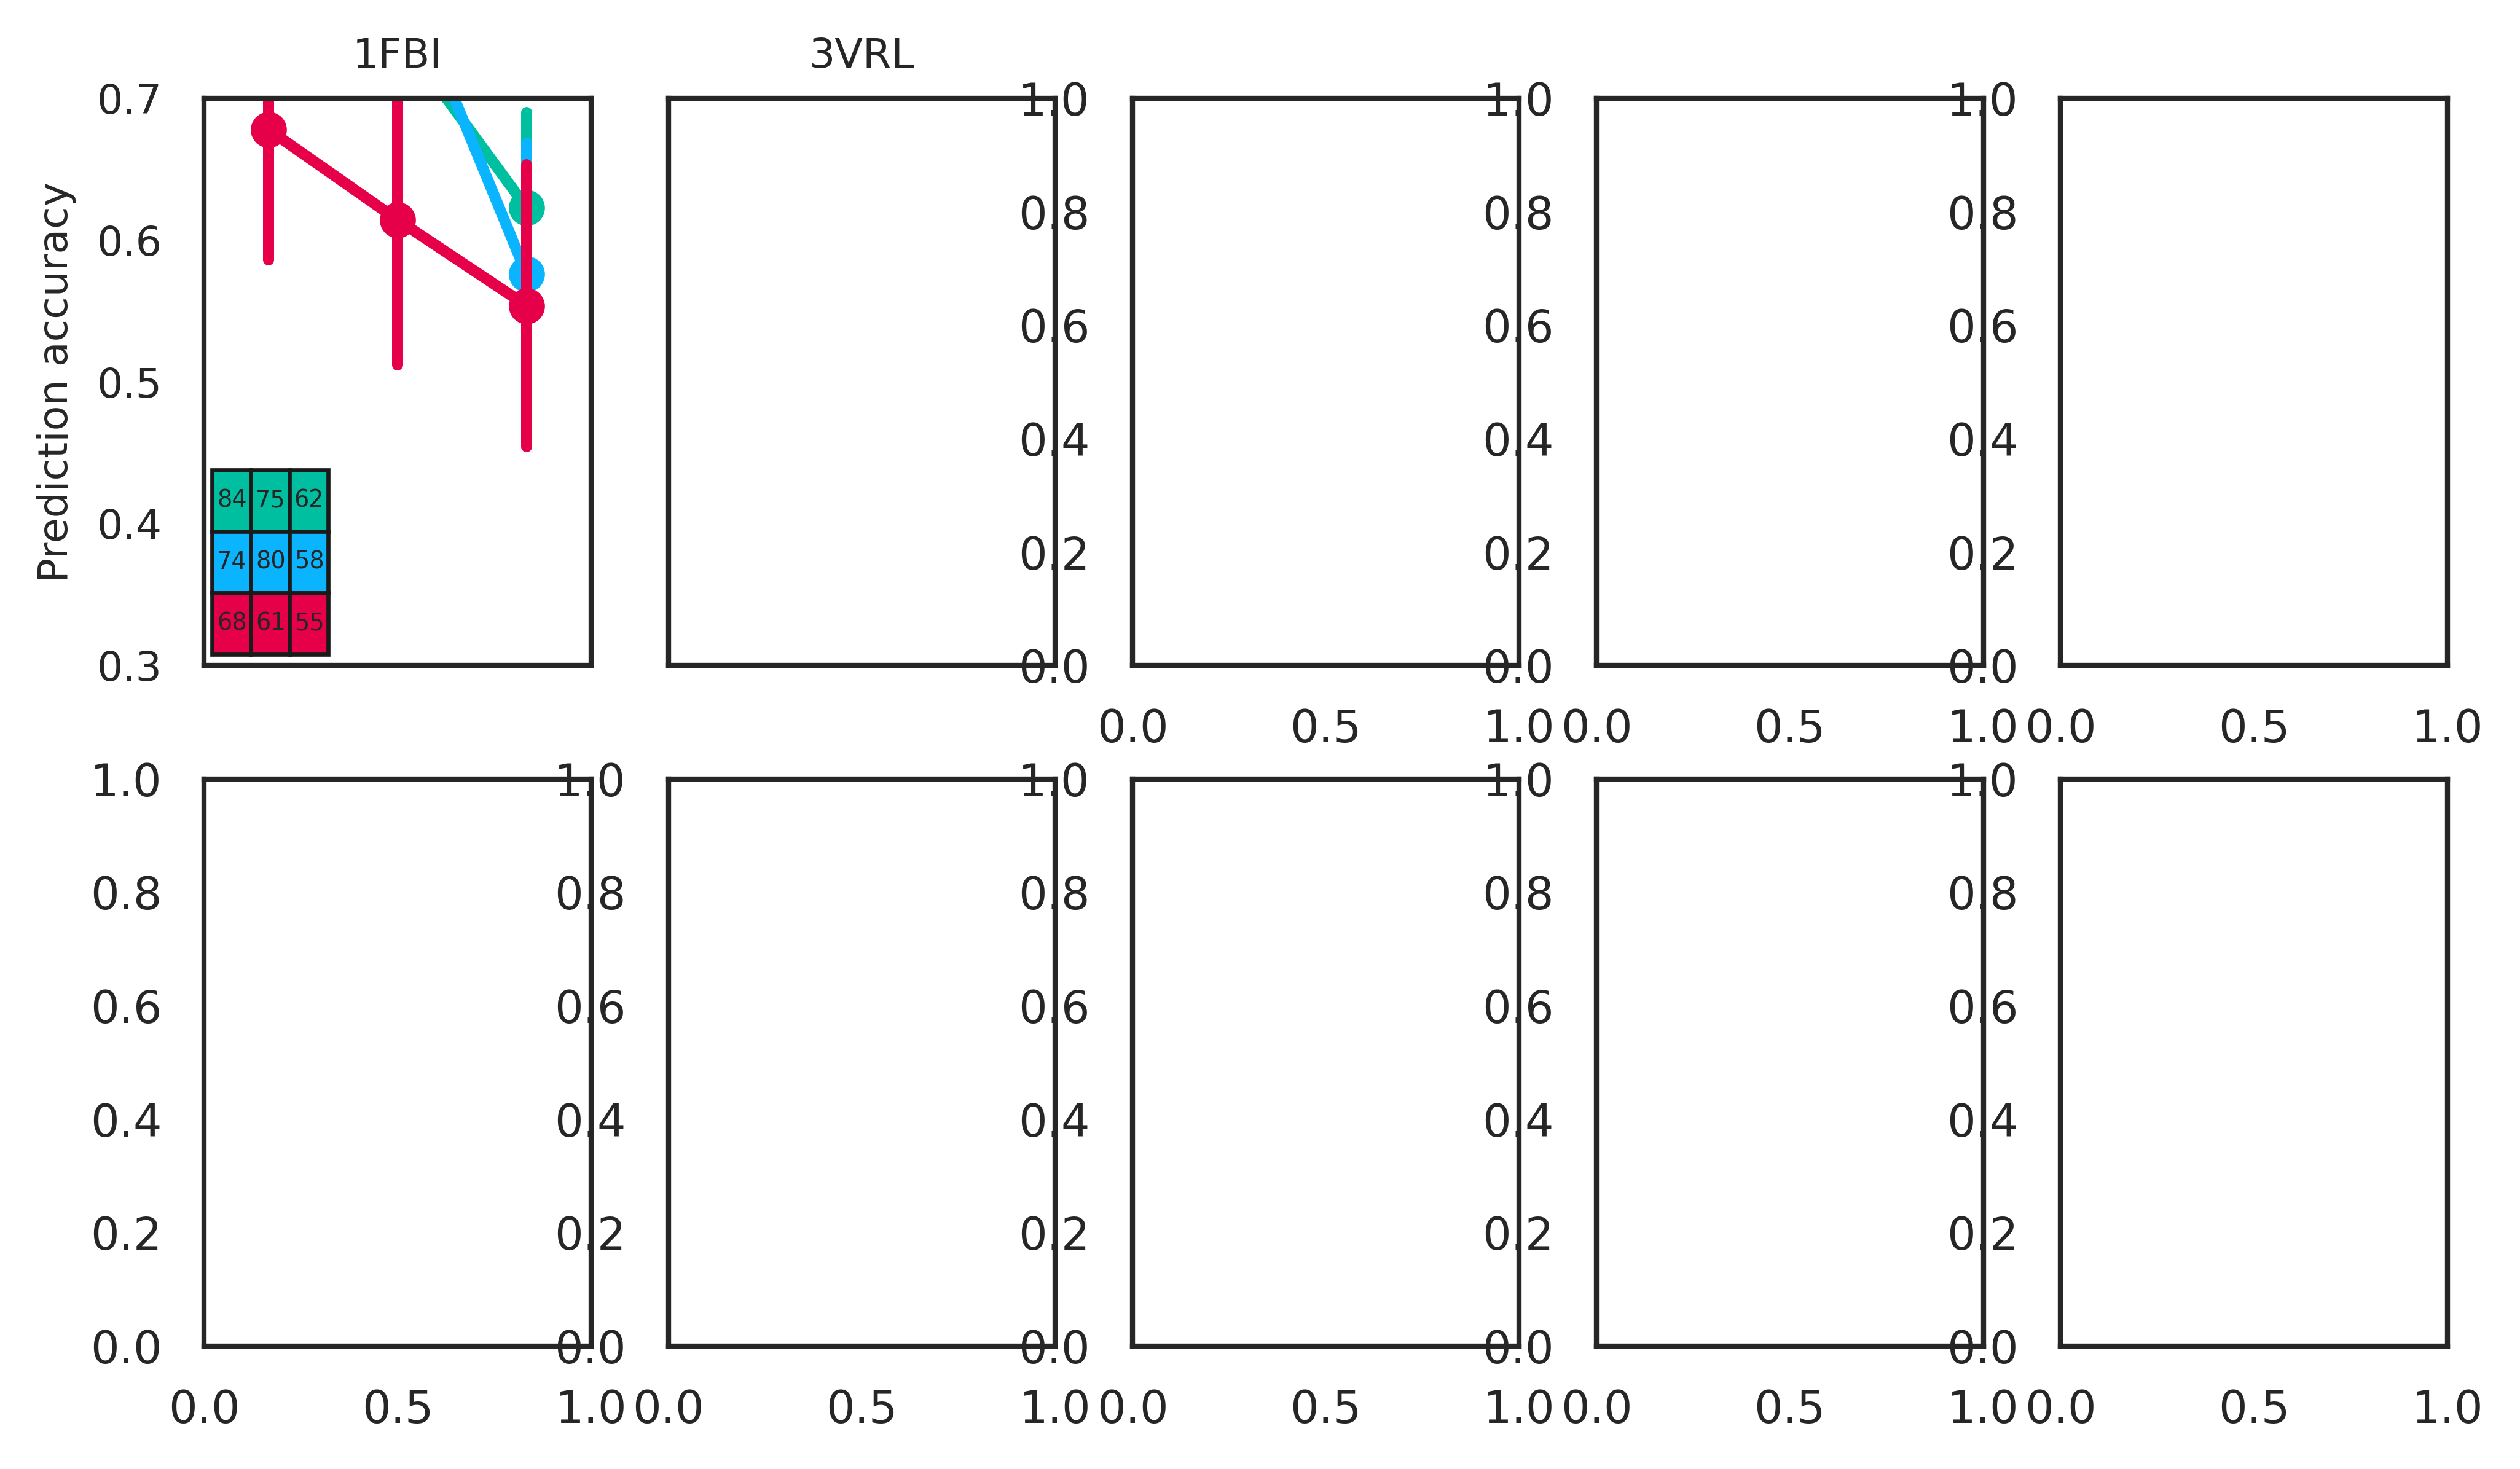

In [20]:
cmap = [
    # Selection from Dutch Field
    "#00bfa0",  # Dark Green
    "#0bb4ff",  # Blue
    "#e60049",  # Red
]
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(2.5 * 3.14, 1.4 * 3.14), dpi=600)

task_order = visualisations.PlotParams.order_tasks_clean.copy()
task_order.remove("vs 1")

for i, ag in enumerate(visualisations.PlotParams.order_antigens):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    df_i = df_o.query("ag == @ag")
    sns.pointplot(
        df_i,
        x="test_task",
        y="acc",
        order=task_order,
        hue="model_task",
        hue_order=task_order,
        errorbar="sd",
        # palette=visualisations.PlotParams.cmap_tasks_no1v1,
        palette=cmap,
        ax=ax,
    )

    ax.legend().remove()

    ax.set_xlabel(None)
    if row == 0:
        ax.set_xticks([])
    elif row == 1:
        for tick in ax.get_xticklabels():
            # tick.set_rotation(45)
            # 45 degree rotation, but with the text centered
            tick.set_rotation(45)
            tick.set_horizontalalignment("right")

    ax.set_ylim(0.3, 0.7)
    ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7])
    if col == 0:
        ax.set_ylabel("Prediction accuracy", fontsize=8)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel(None)

    ax.set_title(f"{ag}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=8)

    # Tables inside the plot
    if row == 1 and col in [1, 2]:
        loc = "lower center"
    else:
        loc = "lower left"
    table_values = (
        df_i.groupby(["model_task", "test_task"])["acc"]
        .mean()
        .reset_index()
        .pivot(index="model_task", columns="test_task", values="acc")
        .loc[task_order][task_order]
        .values * 100).round().astype(int)
    table_values = np.where(table_values == 100, "", table_values)
    ax.table(
        cellText=table_values,
        loc=loc,
        colWidths=[0.1, 0.1, 0.1],
        cellColours=np.array([cmap for _ in range(3)]).transpose(),
    )

# Add one legend horizontal above all subplots, as part of figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    title_fontsize=8,
)

# Add text horizontal under all subplots, as part of figure
# fig.text(0.5, 0.001, "Tested on", ha="center", fontsize=8);

# fig.savefig("figures/1D1.svg")
fig.show()

/tmp/ipykernel_666166/3149022934.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


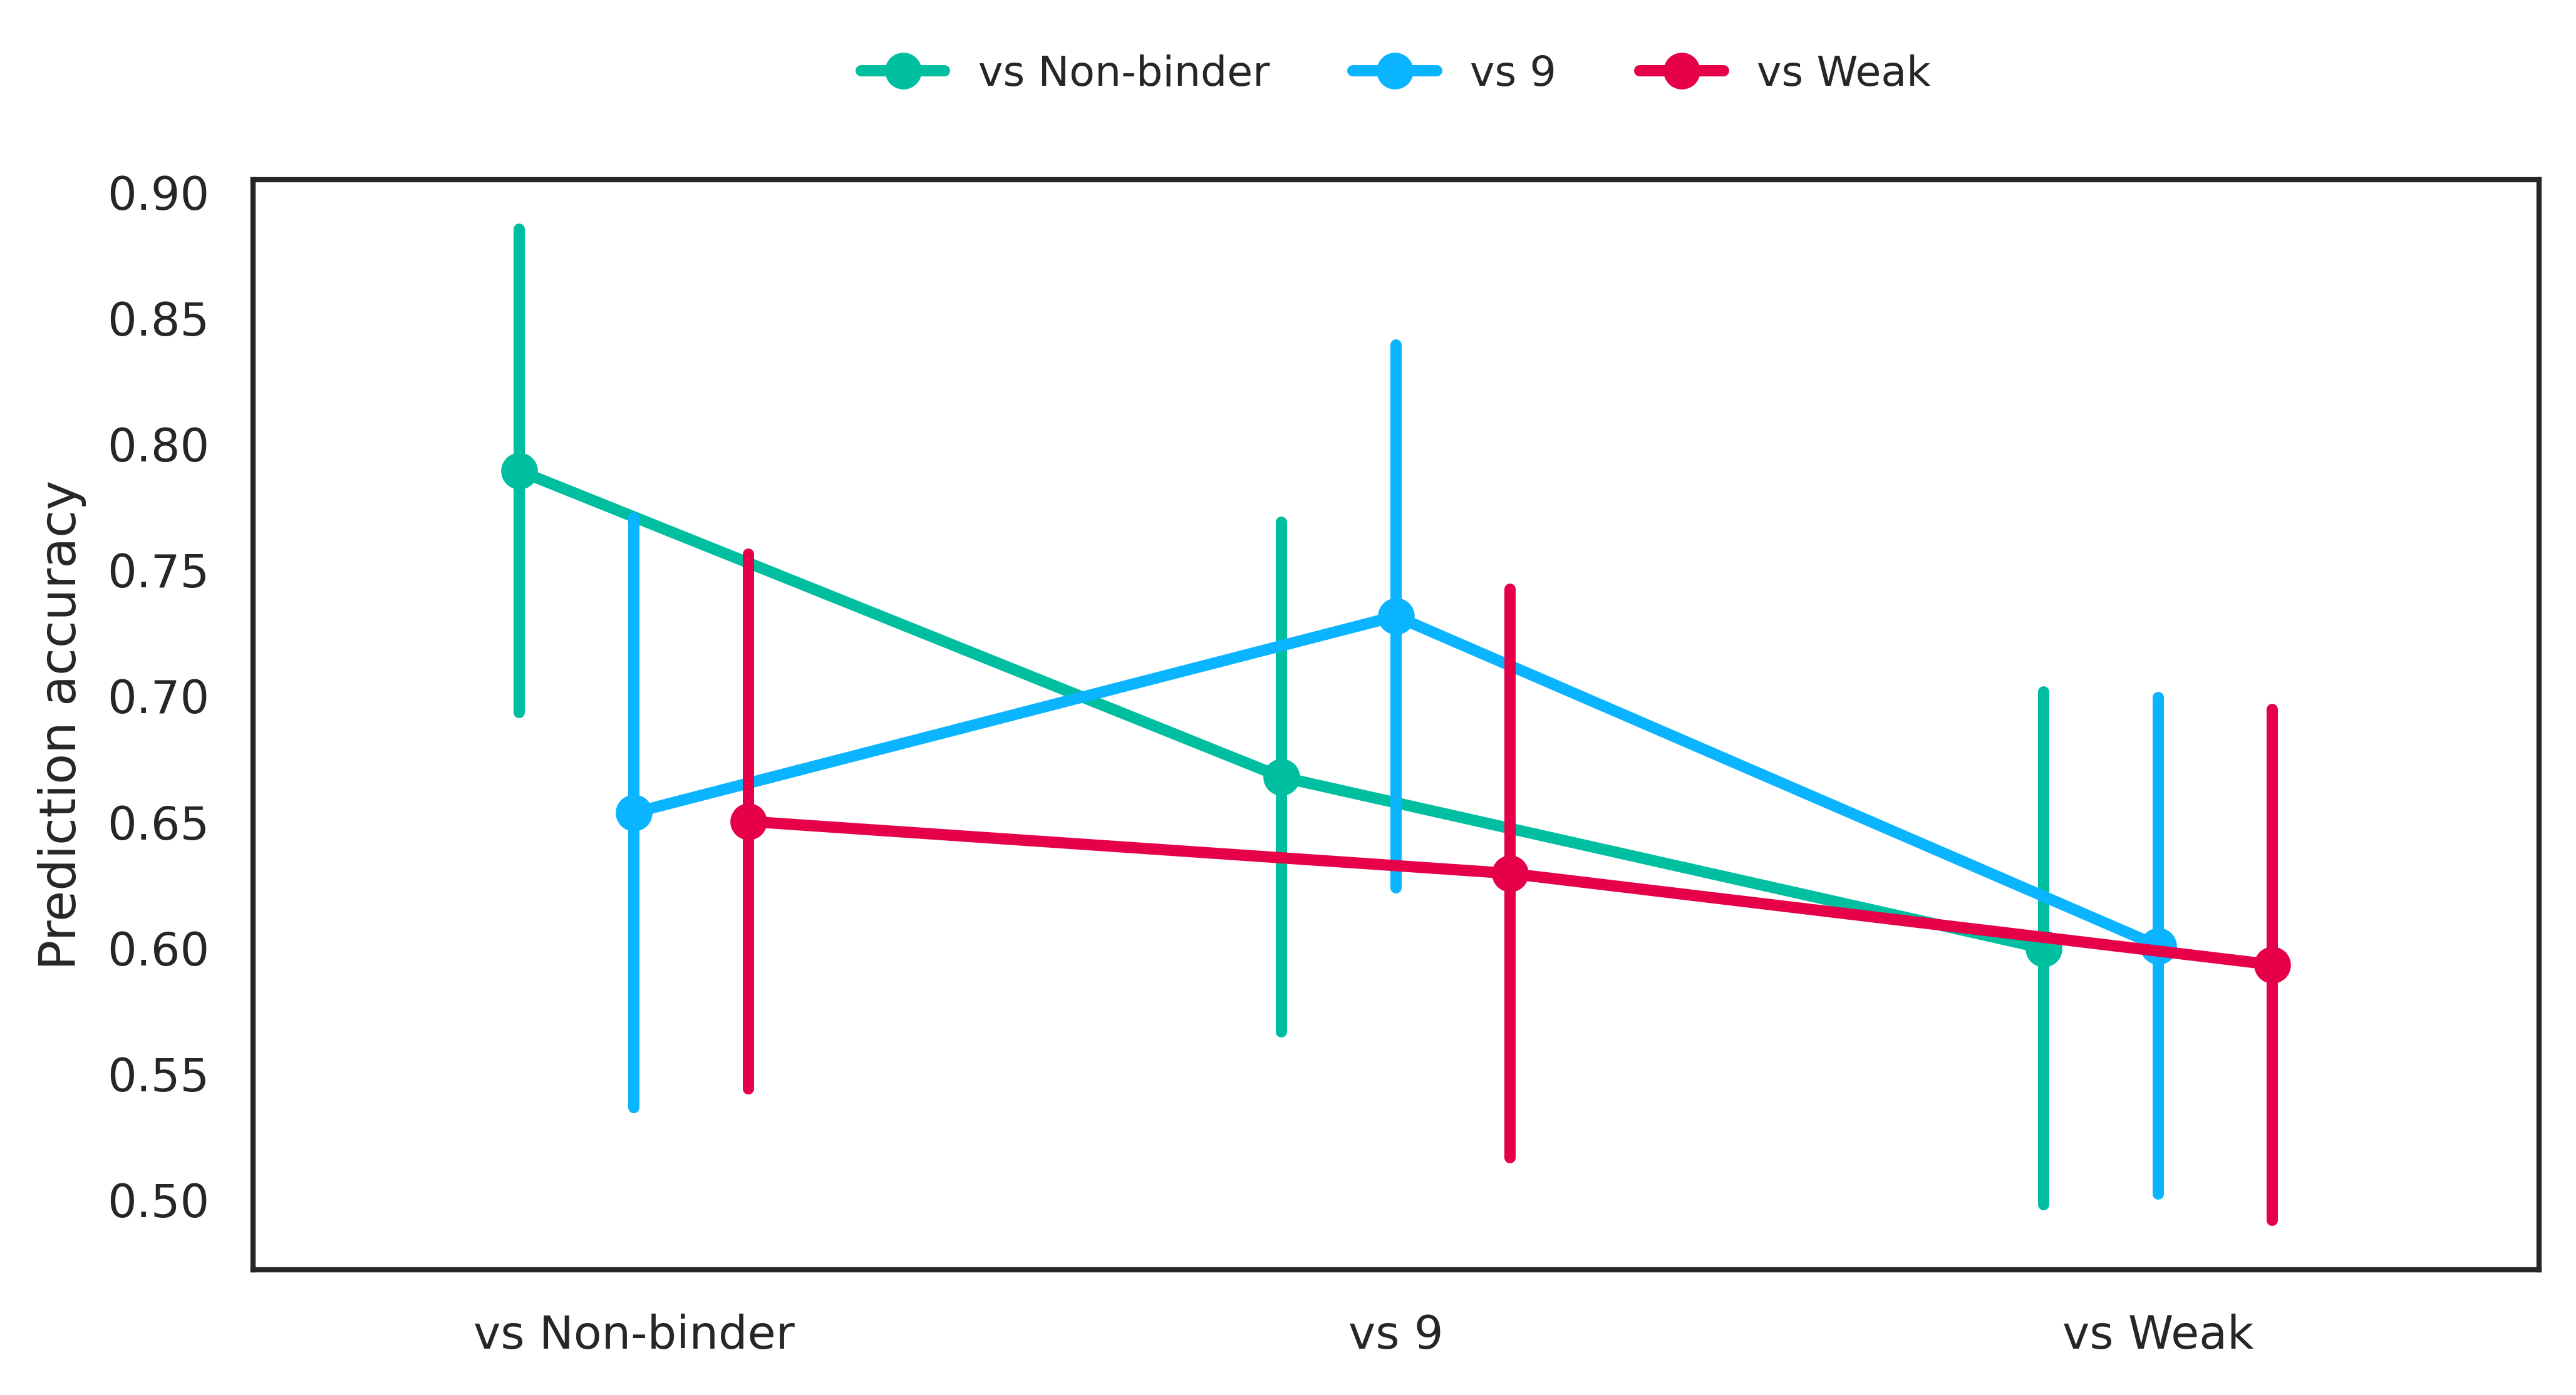

In [21]:
fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.2 * 3.14), dpi=600)
sns.pointplot(
    df_o,
    y="acc",
    x="test_task",
    errorbar="sd",
    order=task_order,
    hue="model_task",
    hue_order=task_order,
    palette=cmap,
    # Spread out the points a bit in horizontal
    dodge=0.3,
    ax=ax,
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")

# Add text
for i, col in enumerate(ax.collections):
    for j, txt in enumerate(col.get_offsets()[:, 0]):
        ax.text(
            txt,
            col.get_offsets()[j, 1],
            f"{col.get_offsets()[j, 1]:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=8,
            fontweight="bold",
        )

# fig.savefig("figures/1D2.svg")
fig.show()

In [22]:
(
    df_o.groupby(["model_task", "test_task"])["acc"].agg(["mean", "std", "size"])
    .round(3).reset_index()
    .query("model_task != test_task")
)

,model_task,test_task,mean,std,size
1,vs 1,vs 9,0.694,0.109,4779
2,vs 1,vs Non-binder,0.611,0.109,4779
3,vs 1,vs Weak,0.566,0.093,4779
4,vs 9,vs 1,0.731,0.119,4455
6,vs 9,vs Non-binder,0.653,0.117,495
7,vs 9,vs Weak,0.601,0.099,495
8,vs Non-binder,vs 1,0.649,0.123,4374
9,vs Non-binder,vs 9,0.668,0.101,486
11,vs Non-binder,vs Weak,0.600,0.102,486
12,vs Weak,vs 1,0.622,0.122,4374


In [23]:
# Computing the JSD for out-of-distribution testing
# We have the JSDs in the df, we can just add them.

df_o = pd.merge(df_o, df[["task", "jsd"]], left_on="task_1", right_on="task")
df_o = df_o.rename(columns={"jsd": "jsd_model"})
df_o = pd.merge(df_o, df[["task", "jsd"]], left_on="task_2", right_on="task")
df_o = df_o.rename(columns={"jsd": "jsd_test"})

# Add in-distribution performance from df
df_o = pd.merge(df_o, df[["task", "acc_closed"]], left_on="task_1", right_on="task")
df_o = df_o.rename(columns={"acc_closed": "acc_id"})

In [24]:
df_ood = df_o.query("model_task != test_task").copy()
df_ood["jsd_diff"] = df_ood["jsd_test"] - df_ood["jsd_model"]
df_ood["acc_diff"] = df_ood["acc"] - df_ood["acc_id"]

df_ood

,task_1,task_2,acc,recall,precision,f1,ag,task_1_type,task_2_type,replicate_id,model_task,test_task,task_x,jsd_model,task_y,jsd_test,task,acc_id,jsd_diff,acc_diff
9,ONE_VS_ONE__1NSN__3VRL__0__42,HIGH_VS_95LOW__1NSN__auto__0__42,0.50,0.6,0.500000,0.545455,1NSN,1v1,high_vs_95low,0_42,vs 1,vs Non-binder,ONE_VS_ONE__1NSN__3VRL__0__42,6.242485,HIGH_VS_95LOW__1NSN__auto__0__42,6.625535,ONE_VS_ONE__1NSN__3VRL__0__42,0.35,0.383050,0.15
10,ONE_VS_ONE__1NSN__3VRL__0__42,HIGH_VS_LOOSER__1NSN__auto__0__42,0.45,0.6,0.461538,0.521739,1NSN,1v1,high_vs_looser,0_42,vs 1,vs Weak,ONE_VS_ONE__1NSN__3VRL__0__42,6.242485,HIGH_VS_LOOSER__1NSN__auto__0__42,6.846561,ONE_VS_ONE__1NSN__3VRL__0__42,0.35,0.604076,0.10
11,ONE_VS_ONE__1NSN__3VRL__0__42,ONE_VS_NINE__1NSN__auto__0__42,0.55,0.6,0.545455,0.571429,1NSN,1v1,1v9,0_42,vs 1,vs 9,ONE_VS_ONE__1NSN__3VRL__0__42,6.242485,ONE_VS_NINE__1NSN__auto__0__42,7.107444,ONE_VS_ONE__1NSN__3VRL__0__42,0.35,0.864959,0.20
12,ONE_VS_ONE__1NSN__3VRL__0__42,HIGH_VS_95LOW__1NSN__auto__1__42,0.50,0.6,0.500000,0.545455,1NSN,1v1,high_vs_95low,0_42,vs 1,vs Non-binder,ONE_VS_ONE__1NSN__3VRL__0__42,6.242485,HIGH_VS_95LOW__1NSN__auto__1__42,6.625535,ONE_VS_ONE__1NSN__3VRL__0__42,0.35,0.383050,0.15
13,ONE_VS_ONE__1NSN__3VRL__0__42,HIGH_VS_LOOSER__1NSN__auto__1__42,0.45,0.6,0.461538,0.521739,1NSN,1v1,high_vs_looser,0_42,vs 1,vs Weak,ONE_VS_ONE__1NSN__3VRL__0__42,6.242485,HIGH_VS_LOOSER__1NSN__auto__1__42,6.846561,ONE_VS_ONE__1NSN__3VRL__0__42,0.35,0.604076,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74944,ONE_VS_NINE__1OB1__auto__0__4,HIGH_VS_LOOSER__1OB1__auto__0__2,0.60,0.8,0.571429,0.666667,1OB1,1v9,high_vs_looser,0_4,vs 9,vs Weak,ONE_VS_NINE__1OB1__auto__0__4,6.931615,HIGH_VS_LOOSER__1OB1__auto__0__2,6.080074,ONE_VS_NINE__1OB1__auto__0__4,0.40,-0.851541,0.20
74946,ONE_VS_NINE__1OB1__auto__0__4,HIGH_VS_95LOW__1OB1__auto__0__3,0.55,0.7,0.538462,0.608696,1OB1,1v9,high_vs_95low,0_4,vs 9,vs Non-binder,ONE_VS_NINE__1OB1__auto__0__4,6.931615,HIGH_VS_95LOW__1OB1__auto__0__3,6.738191,ONE_VS_NINE__1OB1__auto__0__4,0.40,-0.193424,0.15
74947,ONE_VS_NINE__1OB1__auto__0__4,HIGH_VS_LOOSER__1OB1__auto__0__3,0.65,0.7,0.636364,0.666667,1OB1,1v9,high_vs_looser,0_4,vs 9,vs Weak,ONE_VS_NINE__1OB1__auto__0__4,6.931615,HIGH_VS_LOOSER__1OB1__auto__0__3,6.833162,ONE_VS_NINE__1OB1__auto__0__4,0.40,-0.098453,0.25
74949,ONE_VS_NINE__1OB1__auto__0__4,HIGH_VS_95LOW__1OB1__auto__0__4,0.50,0.8,0.500000,0.615385,1OB1,1v9,high_vs_95low,0_4,vs 9,vs Non-binder,ONE_VS_NINE__1OB1__auto__0__4,6.931615,HIGH_VS_95LOW__1OB1__auto__0__4,7.164617,ONE_VS_NINE__1OB1__auto__0__4,0.40,0.233002,0.10


In [25]:
from scipy.stats import pearsonr
# Compute correlation coefficient, p-value and R2
# for jsd_diff and acc_diff per model_task and test_task
for i, df_g in df_ood.groupby(["model_task", "test_task"]):
    r, pval = pearsonr(df_g["jsd_diff"], df_g["acc_diff"])
    print(f"{i}: r={r:.2f}, p={pval:.2f}")
    # R2
    r2 = r**2
    print(f"{i}: R2={r2:.2f}")

    # Record in dict
    df_ood.loc[df_g.index, "r"] = r
    df_ood.loc[df_g.index, "pval"] = pval
    df_ood.loc[df_g.index, "r2"] = r2

df_ood_summary = df_ood.groupby(["model_task", "test_task"])[["r", "pval", "r2"]].mean().round(2)
df_ood_summary

('vs 1', 'vs 9'): r=-0.11, p=0.00
('vs 1', 'vs 9'): R2=0.01
('vs 1', 'vs Non-binder'): r=-0.09, p=0.00
('vs 1', 'vs Non-binder'): R2=0.01
('vs 1', 'vs Weak'): r=-0.01, p=0.37
('vs 1', 'vs Weak'): R2=0.00
('vs 9', 'vs 1'): r=0.05, p=0.00
('vs 9', 'vs 1'): R2=0.00
('vs 9', 'vs Non-binder'): r=-0.13, p=0.00
('vs 9', 'vs Non-binder'): R2=0.02
('vs 9', 'vs Weak'): r=-0.05, p=0.24
('vs 9', 'vs Weak'): R2=0.00
('vs Non-binder', 'vs 1'): r=0.10, p=0.00
('vs Non-binder', 'vs 1'): R2=0.01
('vs Non-binder', 'vs 9'): r=-0.03, p=0.56
('vs Non-binder', 'vs 9'): R2=0.00
('vs Non-binder', 'vs Weak'): r=0.05, p=0.24
('vs Non-binder', 'vs Weak'): R2=0.00
('vs Weak', 'vs 1'): r=-0.11, p=0.00
('vs Weak', 'vs 1'): R2=0.01
('vs Weak', 'vs 9'): r=-0.11, p=0.02
('vs Weak', 'vs 9'): R2=0.01
('vs Weak', 'vs Non-binder'): r=-0.16, p=0.00
('vs Weak', 'vs Non-binder'): R2=0.03


r  pval    r2
model_task    test_task                      
vs 1          vs 9          -0.11  0.00  0.01
              vs Non-binder -0.09  0.00  0.01
              vs Weak       -0.01  0.37  0.00
vs 9          vs 1           0.05  0.00  0.00
              vs Non-binder -0.13  0.00  0.02
              vs Weak       -0.05  0.24  0.00
vs Non-binder vs 1           0.10  0.00  0.01
              vs 9          -0.03  0.56  0.00
              vs Weak        0.05  0.24  0.00
vs Weak       vs 1          -0.11  0.00  0.01
              vs 9          -0.11  0.02  0.01
              vs Non-binder -0.16  0.00  0.03

In [26]:
df_ood_summary["text"] = df_ood_summary.apply(lambda x: f"r={x['r']}, p={x['pval']}, R2={x['r2']}", axis=1)
df_ood_summary.reset_index()

,model_task,test_task,r,pval,r2,text
0,vs 1,vs 9,-0.11,0.00,0.01,"r=-0.11, p=0.0, R2=0.01"
1,vs 1,vs Non-binder,-0.09,0.00,0.01,"r=-0.09, p=0.0, R2=0.01"
2,vs 1,vs Weak,-0.01,0.37,0.00,"r=-0.01, p=0.37, R2=0.0"
3,vs 9,vs 1,0.05,0.00,0.00,"r=0.05, p=0.0, R2=0.0"
4,vs 9,vs Non-binder,-0.13,0.00,0.02,"r=-0.13, p=0.0, R2=0.02"
5,vs 9,vs Weak,-0.05,0.24,0.00,"r=-0.05, p=0.24, R2=0.0"
6,vs Non-binder,vs 1,0.10,0.00,0.01,"r=0.1, p=0.0, R2=0.01"
7,vs Non-binder,vs 9,-0.03,0.56,0.00,"r=-0.03, p=0.56, R2=0.0"
8,vs Non-binder,vs Weak,0.05,0.24,0.00,"r=0.05, p=0.24, R2=0.0"
9,vs Weak,vs 1,-0.11,0.00,0.01,"r=-0.11, p=0.0, R2=0.01"
